# Place to test creating small NDNT networks to see how they work

In [72]:
import sys
# not best practice, but makes it easier to import from subdirectory
sys.path.insert(0, './lib')

import numpy as np
import torch
from copy import deepcopy

import NDNT.utils as utils
import NDNT.NDNT as NDN
from NDNT.modules.layers import ChannelLayer, NDNLayer
from NDNT.networks import FFnetwork
import NTdatasets.HN.HNdatasets as datasets
from NTdatasets.sensory_base import SensoryBase

from importlib import reload

import modellib as ml

def redo():
    reload(ml)


In [73]:
# create test dataset to fit with a model
class TestDataset(SensoryBase):
    def __init__(self):
        # in this case, we don't need to call the parent constructor
        #               since it is made up for the test
        # this is the minimum set of data necessary to train a model
        # at least, when the __getitem()__ returns a dictionary
        # __getitem()__ can return a flat vector, I believe
        self.stim = torch.rand(1000, 132)
        self.robs = torch.rand(1000, 31)
        self.dfs = torch.ones(1000, 31) # datafilter, 1 when valid, 0 when not
        self.val_inds = range(0, 1000) # this is for validation
        self.train_inds = range(0, 1000) # this is for training
        self.NT = 1000 # this is the number of timepoints
        # DANBUG: these should be moved to SensoryBase if it is referenced in the superclass
        self.cov_dims = {}
        self.covariates = {}
        ###############

    # this returns the item at the given index
    def __getitem__(self, i):
        out = {
            'stim': self.stim[i,:],
            'robs': self.robs[i,:],
            'dfs': self.dfs[i, :]
        }
        if len(self.covariates) > 0:
            self.append_covariates(out, i)
        return out


In [81]:
data = TestDataset() # create the test data to train on
data.add_covariate('cov', torch.rand(1000, 132))
data.__getitem__(0).keys()

dict_keys(['stim', 'robs', 'dfs', 'cov'])

In [80]:
lbfgs_pars = utils.create_optimizer_params(
    optimizer_type='lbfgs',
    tolerance_change=1e-10,
    tolerance_grad=1e-10,
    batch_size=2000,
    history_size=100,
    max_epochs=3,
    max_iter = 2000)

# TODO: validate that is learns something
# TODO: add in another covariate (smoothed_robs) and make sure it works correctly
# TODO: then, we can easily add new covariates in as we desire, and combine them as well

# define the layers (inputs and outputs)
Dreg = 0.005
pars = NDNLayer.layer_dict(
    input_dims=[1,11,1,12], num_filters=31, bias=False, norm_type=0, NLtype='lin')
pars['reg_vals'] = {'d2t': Dreg, 'bcs':{'d2t':0}}
parsN = deepcopy(pars)
parsN['NLtype'] = 'softplus'

# define the network
# xstim_n = the key for the data provided by the dataset
netN = FFnetwork.ffnet_dict(xstim_n = 'stim', layer_list = [parsN] )

cov_layer = NDNLayer.layer_dict(
    input_dims=[1, 11, 1, 12], num_filters=31, bias=False, norm_type=0, NLtype='lin')
smoothed_net = FFnetwork.ffnet_dict(xstim_n='cov', layer_list=[cov_layer])

comb_layer = ChannelLayer.layer_dict(num_filters=31) # just return 1 output
comb_net = FFnetwork.ffnet_dict(xstim_n=None, ffnet_n=[0, 1], layer_list=[comb_layer], ffnet_type='add')

# define the model
model = NDN.NDN(ffnet_list = [netN, smoothed_net, comb_net], loss_type='poisson')

# train the model
model.fit(data, force_dict_training=True, **lbfgs_pars, verbose=0)

# evaluate model using null-adjusted log-likelihood
# TODO: these val_inds are all the indices. This is NOT correct.
LLsNULL = model.eval_models(data[data.val_inds], null_adjusted=False)
print("Mean LL-null:", np.mean(LLsNULL))
LLsNULL

Mean LL-null: nan


array([      nan,       nan,       nan,       nan, 2.1651614,       nan,
             nan,       nan,       nan,       nan,       nan,       nan,
       1.8424454,       nan,       nan,       nan,       nan,       nan,
             nan,       nan,       nan,       nan,       nan,       nan,
             nan,       nan,       nan,       nan,       nan,       nan,
             nan], dtype=float32)

stim None
cov None
None [0, 1]


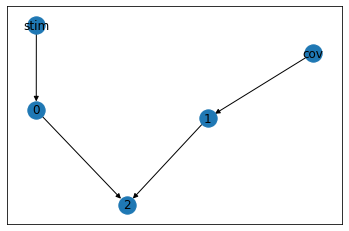

In [82]:
ml.draw_network(model)